# Modeling Cross Section Data with DT

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

# This allows us to import the nucml utilities
sys.path.append("../..")

import nucml.exfor.data_utilities as exfor_utils 
import nucml.datasets as nuc_data 
import nucml.model.utilities as model_utils

In [2]:
import importlib
importlib.reload(exfor_utils)
importlib.reload(nuc_data)
importlib.reload(model_utils)
print("Finish re-loading scripts.")

Finish re-loading scripts.


# Inspecting Decision Tree Training Parameters

In [3]:
results_b0 = pd.read_csv("dt_resultsB0.csv").sort_values(by="max_depth")
results_b1 = pd.read_csv("dt_resultsB1.csv").sort_values(by="max_depth")
results_b2 = pd.read_csv("dt_resultsB2.csv").sort_values(by="max_depth")
results_b3 = pd.read_csv("dt_resultsB3.csv").sort_values(by="max_depth")
results_b4 = pd.read_csv("dt_resultsB4.csv").sort_values(by="max_depth")
# results_b0.shape

In [4]:
b0_min = results_b0.train_mae.min()
b1_min = results_b1.train_mae.min()
b2_min = results_b2.train_mae.min()
b3_min = results_b3.train_mae.min()
b4_min = results_b4.train_mae.min()

best_dataset = pd.DataFrame({"Train_MAE":[b0_min, b1_min, b2_min, b3_min, b4_min], "Dataset":["A", "B", "C", "D", "E"]})
best_dataset[best_dataset.Train_MAE == best_dataset.Train_MAE.min()]

,Train_MAE,Dataset
0,0.025773,A


In [5]:
b0_min = results_b0.val_mae.min()
b1_min = results_b1.val_mae.min()
b2_min = results_b2.val_mae.min()
b3_min = results_b3.val_mae.min()
b4_min = results_b4.val_mae.min()

best_dataset = pd.DataFrame({"Train_MAE":[b0_min, b1_min, b2_min, b3_min, b4_min], "Dataset":["A", "B", "C", "D", "E"]})
best_dataset[best_dataset.Train_MAE == best_dataset.Train_MAE.min()]

,Train_MAE,Dataset
1,0.118699,B


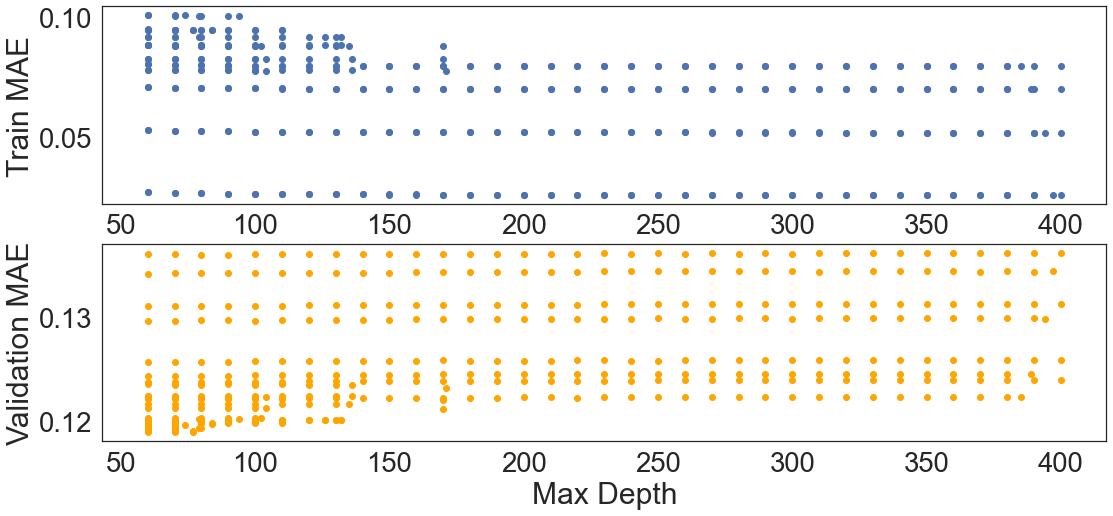

In [6]:
def max_depth_plot(df, save=False, name="max_depth_plot", close=False):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))
    ax1.scatter(df.max_depth, df.train_mae)
    ax2.scatter(df.max_depth, df.val_mae, c="orange")
    ax2.set_xlabel("Max Depth")
    ax1.set_ylabel("Train MAE")
    ax2.set_ylabel("Validation MAE")
    if save:
        plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
    if close:
        plt.close()
    
max_depth_plot(results_b0)

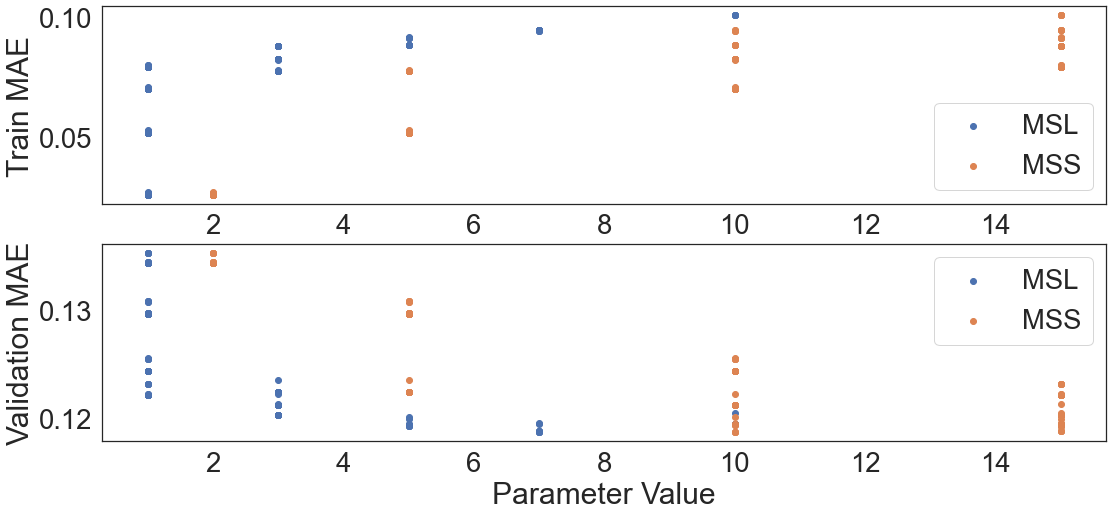

In [7]:
def mss_msl_plot(df, save=False, name="mss_msl_plot", close=False):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))
    ax1.scatter(df.msl, df.train_mae, label="MSL")
    ax1.scatter(df.mss, df.train_mae, label="MSS")
    ax2.scatter(df.msl, df.val_mae, label="MSL")
    ax2.scatter(df.mss, df.val_mae, label="MSS")
    ax1.legend()
    ax2.legend()
    ax2.set_xlabel("Parameter Value")
    ax1.set_ylabel("Train MAE")
    ax2.set_ylabel("Validation MAE")
    if save:
        plt.savefig(os.path.join("figures/", name + ".png"), bbox_inches='tight', dpi=300)
    if close:
        plt.close()
    
mss_msl_plot(results_b4)

In [8]:
for df, name in zip([results_b0, results_b1, results_b2, results_b3, results_b4], ["b0", "b1", "b2", "b3", "b4"]):
    max_depth_plot(df, save=True, name=name+"_maxdepth", close=True)
    mss_msl_plot(df, save=True, name=name+"_mss_msl", close=True)

# Getting Best Models

In [9]:
best_b0 = model_utils.get_best_models_df(results_b0, keep_first=True)
best_b1 = model_utils.get_best_models_df(results_b1, keep_first=True)
best_b2 = model_utils.get_best_models_df(results_b2, keep_first=True)
best_b3 = model_utils.get_best_models_df(results_b3, keep_first=True)
best_b4 = model_utils.get_best_models_df(results_b4, keep_first=True)

In [10]:
best_b0["dataset"] = "b0"
best_b1["dataset"] = "b1"
best_b2["dataset"] = "b2"
best_b3["dataset"] = "b3"
best_b4["dataset"] = "b4"

In [11]:
all_best_models = best_b0.append(best_b1).append(best_b2).append(best_b3).append(best_b4)[['dataset', 'max_depth', 'mss', 'msl', 'train_mae', 'val_mae', 'test_mae', 'tag']]
all_best_models = all_best_models[all_best_models.tag == "Val"].drop(columns=['tag'])
all_best_models['dataset'] = ['A', 'B', 'C', 'D', 'E']
all_best_models.columns = ['Dataset', 'Max Depth', 'MSS', 'MSL', 'Train MAE', 'Val MAE', 'Test MAE']
all_best_models

,Dataset,Max Depth,MSS,MSL,Train MAE,Val MAE,Test MAE
30,A,77,10,7,0.094472,0.118891,0.119736
18,B,70,10,7,0.094443,0.118699,0.119142
30,C,79,10,7,0.094436,0.119583,0.119327
18,D,70,10,7,0.094523,0.118764,0.119485
30,E,80,10,7,0.094559,0.118741,0.119347


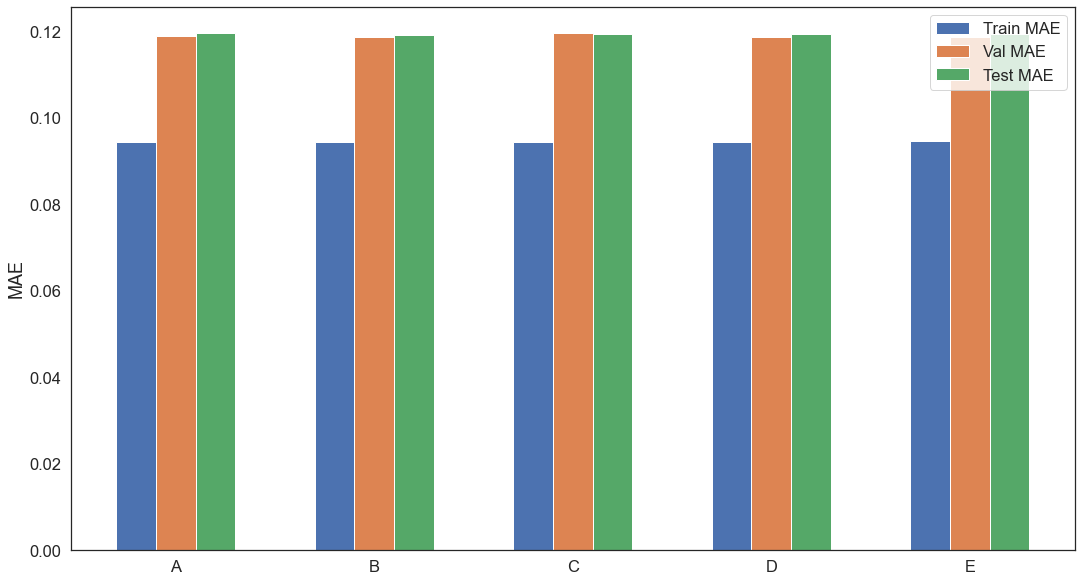

In [38]:
train_mae = all_best_models["Train MAE"].values
val_mae =  all_best_models["Val MAE"].values
test_mae =  all_best_models["Test MAE"].values

x = np.arange(len(all_best_models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(18,10))
rects1 = ax.bar(x - width, train_mae, width, label='Train MAE')
rects2 = ax.bar(x, val_mae, width, label='Val MAE')
rects3 = ax.bar(x + width, test_mae, width, label='Test MAE')

ax.set_ylabel('MAE')
ax.set_xticks(x)
ax.set_xticklabels(all_best_models.Dataset.values)
ax.legend()

In [12]:
print(all_best_models.to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Dataset &  Max Depth &  MSS &  MSL &  Train MAE &  Val MAE &  Test MAE \\
\midrule
      A &         77 &   10 &    7 &   0.094472 & 0.118891 &  0.119736 \\
      B &         70 &   10 &    7 &   0.094443 & 0.118699 &  0.119142 \\
      C &         79 &   10 &    7 &   0.094436 & 0.119583 &  0.119327 \\
      D &         70 &   10 &    7 &   0.094523 & 0.118764 &  0.119485 \\
      E &         80 &   10 &    7 &   0.094559 & 0.118741 &  0.119347 \\
\bottomrule
\end{tabular}



# Hyperparameter Exploration

In [39]:
import seaborn as sns

sns.set(font_scale=1.5)
sns.set_style("white")

from matplotlib import cm

# Max Depth vs MSS

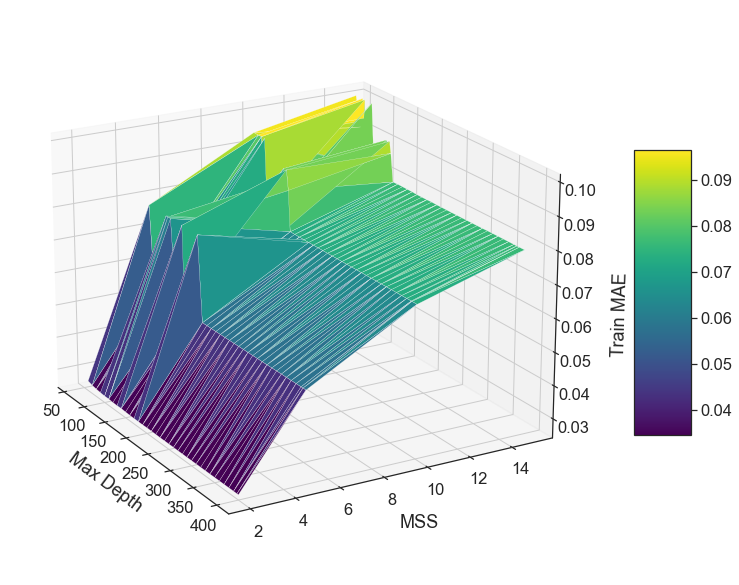

In [40]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.max_depth, results_b0.mss, results_b0.train_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(20, -30)
ax.set_ylabel("MSS", labelpad=15)
ax.set_xlabel("Max Depth", labelpad=10)
ax.set_zlabel("Train MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams.png", bbox_inches='tight', dpi=300)

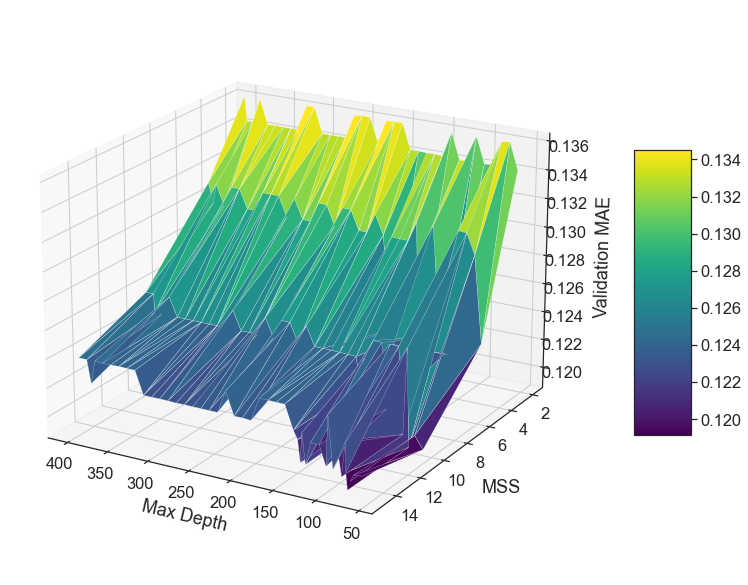

In [161]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.max_depth, results_b0.mss, results_b0.val_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(20, 120)
ax.set_ylabel("MSS", labelpad=15)
ax.set_xlabel("Max Depth", labelpad=10)
ax.set_zlabel("Validation MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams_val.png", bbox_inches='tight', dpi=300)

# Max Depth vs MSL

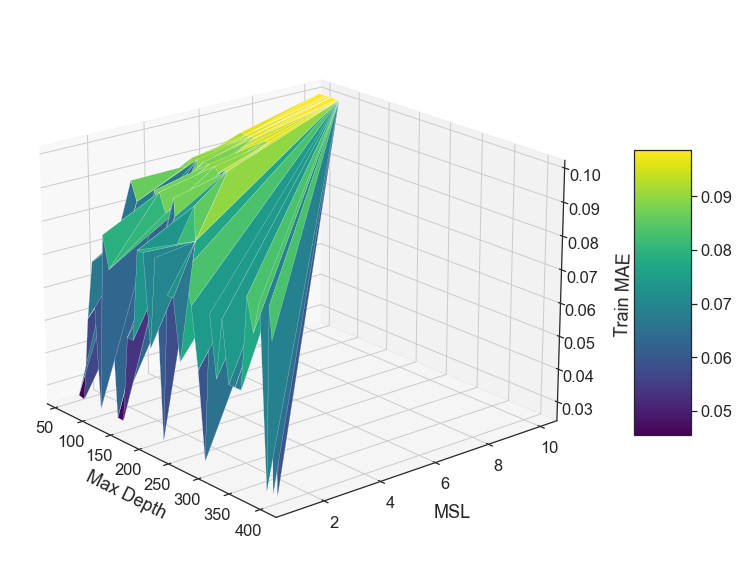

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.max_depth, results_b0.msl, results_b0.train_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(20, -40)
ax.set_ylabel("MSL", labelpad=15)
ax.set_xlabel("Max Depth", labelpad=10)
ax.set_zlabel("Train MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams_msl.png", bbox_inches='tight', dpi=300)

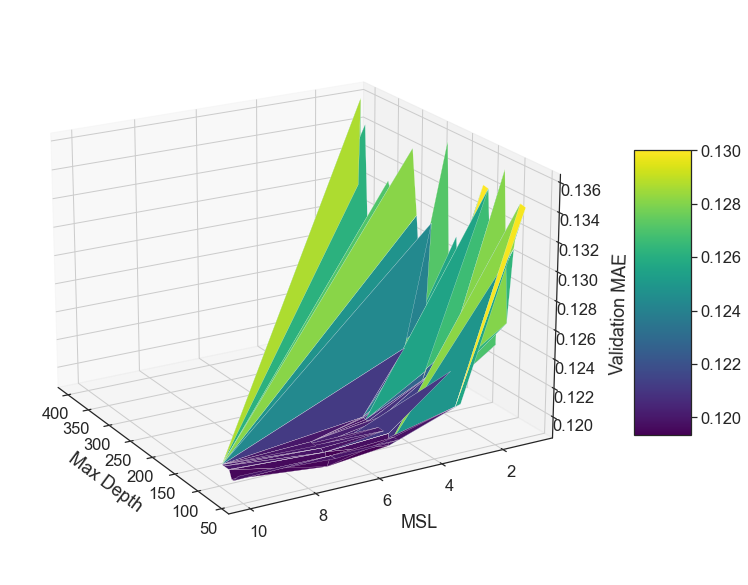

In [180]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.max_depth, results_b0.msl, results_b0.val_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(20, 150)
ax.set_ylabel("MSL", labelpad=15)
ax.set_xlabel("Max Depth", labelpad=10)
ax.set_zlabel("Validation MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams_msl_val.png", bbox_inches='tight', dpi=300)

# MSL vs MSS

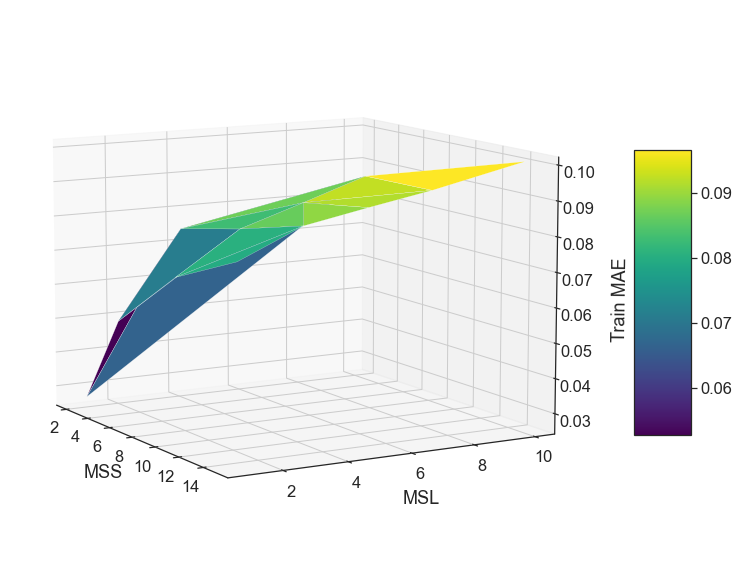

In [110]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.mss, results_b0.msl, results_b0.train_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(10, -30)
ax.set_ylabel("MSL", labelpad=15)
ax.set_xlabel("MSS", labelpad=10)
ax.set_zlabel("Train MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams_msl_mss.png", bbox_inches='tight', dpi=300)

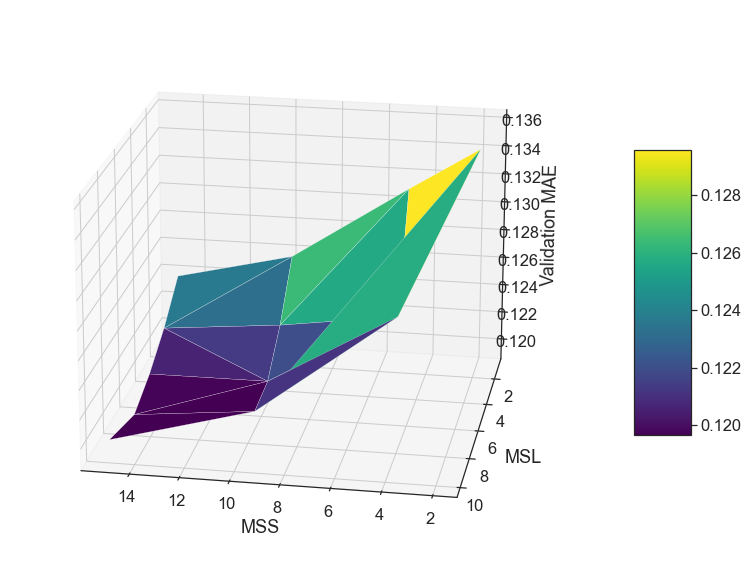

In [107]:
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(20, 10.5, forward=True)
surf = ax.plot_trisurf(results_b0.mss, results_b0.msl, results_b0.val_mae, linewidth=0.2, antialiased=True, cmap=cm.viridis)
ax.view_init(20, 100)
ax.set_ylabel("MSL", labelpad=15)
ax.set_xlabel("MSS", labelpad=10)
ax.set_zlabel("Validation MAE", labelpad=15)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("figures/dt_3d_hyperparams_msl_mss_val.png", bbox_inches='tight', dpi=300)

# Feature Importances

In [201]:
columns_b0 = pd.read_csv("../columns_b0.csv").replace({"Center_of_Mass_Flag_Center_of_Mass":"Center of Mass", "Center_of_Mass_Flag_Lab":"Lab Frame"})
columns_b1 = pd.read_csv("../columns_b1.csv").replace({"Center_of_Mass_Flag_Center_of_Mass":"Center of Mass", "Center_of_Mass_Flag_Lab":"Lab Frame"})
columns_b2 = pd.read_csv("../columns_b2.csv").replace({"Center_of_Mass_Flag_Center_of_Mass":"Center of Mass", "Center_of_Mass_Flag_Lab":"Lab Frame"})
columns_b3 = pd.read_csv("../columns_b3.csv").replace({"Center_of_Mass_Flag_Center_of_Mass":"Center of Mass", "Center_of_Mass_Flag_Lab":"Lab Frame"})
columns_b4 = pd.read_csv("../columns_b4.csv").replace({"Center_of_Mass_Flag_Center_of_Mass":"Center of Mass", "Center_of_Mass_Flag_Lab":"Lab Frame"})

In [203]:
columns_b0 = [x.replace("_", " ") for x in columns_b0.data_columns]
columns_b1 = [x.replace("_", " ") for x in columns_b1.data_columns]
columns_b2 = [x.replace("_", " ") for x in columns_b2.data_columns]
columns_b3 = [x.replace("_", " ") for x in columns_b3.data_columns]
columns_b4 = [x.replace("_", " ") for x in columns_b4.data_columns]

In [114]:
b0_train_model = model_utils.load_model_and_scaler(best_b0.iloc[[0]], model_only=True)
b1_train_model = model_utils.load_model_and_scaler(best_b1.iloc[[0]], model_only=True)
b2_train_model = model_utils.load_model_and_scaler(best_b2.iloc[[0]], model_only=True)
b3_train_model = model_utils.load_model_and_scaler(best_b3.iloc[[0]], model_only=True)
b4_train_model = model_utils.load_model_and_scaler(best_b4.iloc[[0]], model_only=True)

C:\Users\Pedro\Anaconda3\envs\ml_gpu\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [223]:
# from sklearn.inspection import permutation_importance

# perm_import_b0 = permutation_importance(b0_train_model, df_b0.drop(columns=["Data"]), df_b0.Data, n_repeats=10)
# perm_import_b1 = permutation_importance(b1_train_model, df_b1.drop(columns=["Data"]), df_b0.Data, n_repeats=10, n_jobs=-1)

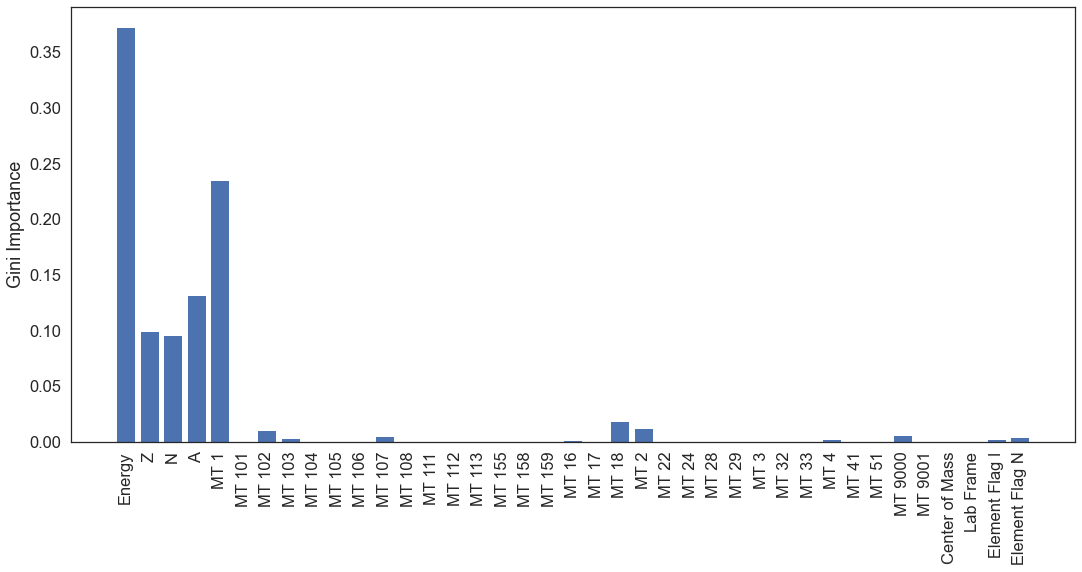

In [225]:
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(b0_train_model.feature_importances_))], b0_train_model.feature_importances_)
plt.xticks(np.arange(len(columns_b0)), columns_b0, rotation=90) 
plt.ylabel("Gini Importance")
plt.savefig("figures/dt_feat_import_b0.png", bbox_inches='tight', dpi=300)
plt.show()

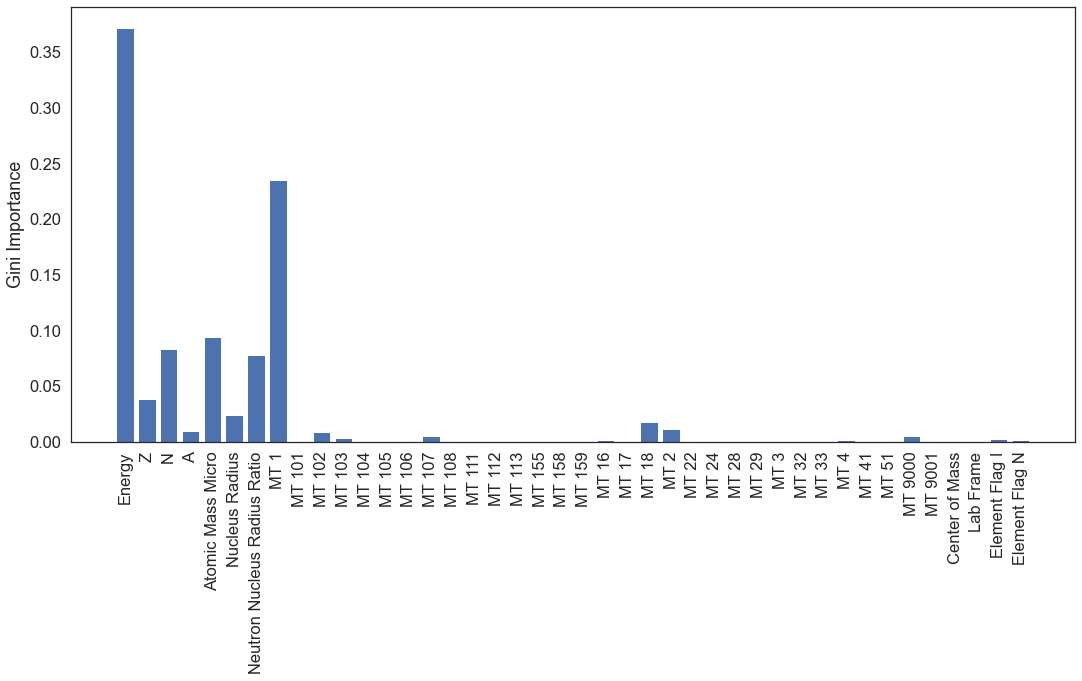

In [234]:
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(b1_train_model.feature_importances_))], b1_train_model.feature_importances_)
plt.xticks(np.arange(len(columns_b1)), columns_b1, rotation=90) 
plt.ylabel("Gini Importance")
plt.savefig("figures/dt_feat_import_b1.png", bbox_inches='tight', dpi=300)
plt.show()

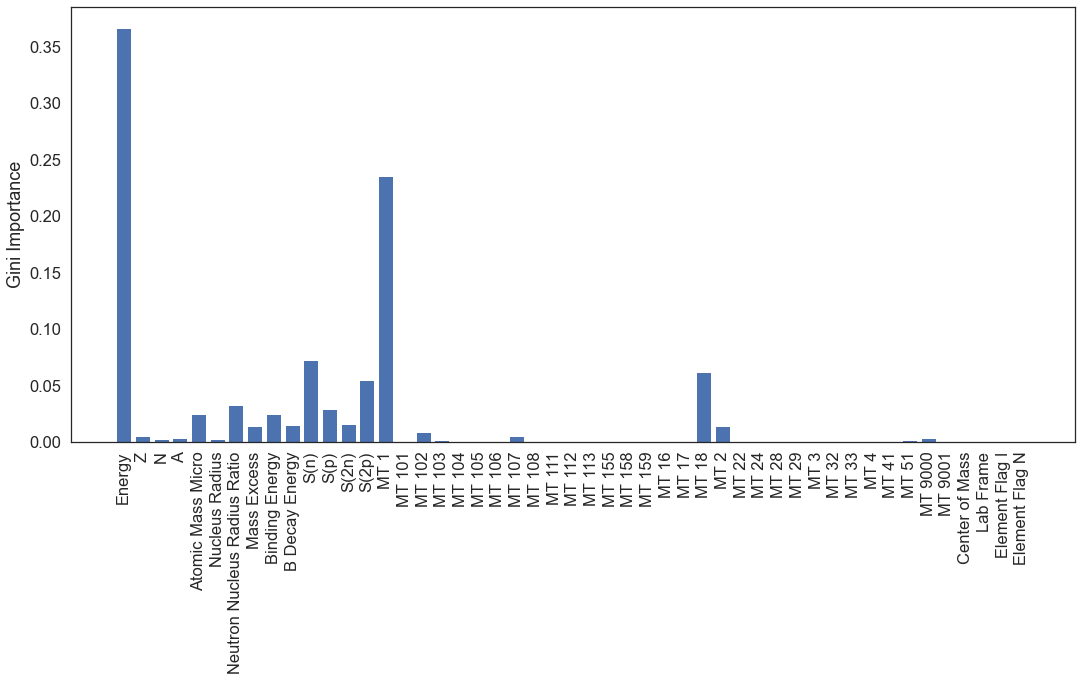

In [236]:
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(b2_train_model.feature_importances_))], b2_train_model.feature_importances_)
plt.xticks(np.arange(len(columns_b2)), columns_b2, rotation=90) 
plt.ylabel("Gini Importance")
plt.savefig("figures/dt_feat_import_b2.png", bbox_inches='tight', dpi=300)
plt.show()

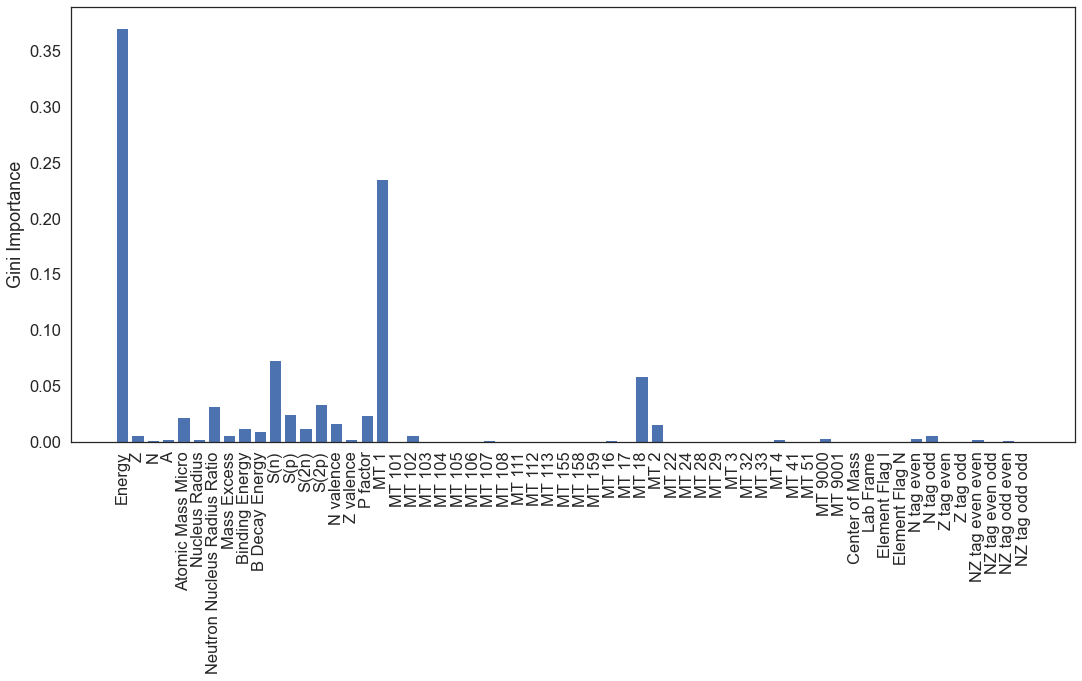

In [230]:
plt.figure(figsize=(18,8))
plt.bar([x for x in range(len(b3_train_model.feature_importances_))], b3_train_model.feature_importances_)
plt.xticks(np.arange(len(columns_b3)), columns_b3, rotation=90) 
plt.ylabel("Gini Importance")
plt.savefig("figures/dt_feat_import_b3.png", bbox_inches='tight', dpi=300)
plt.show()

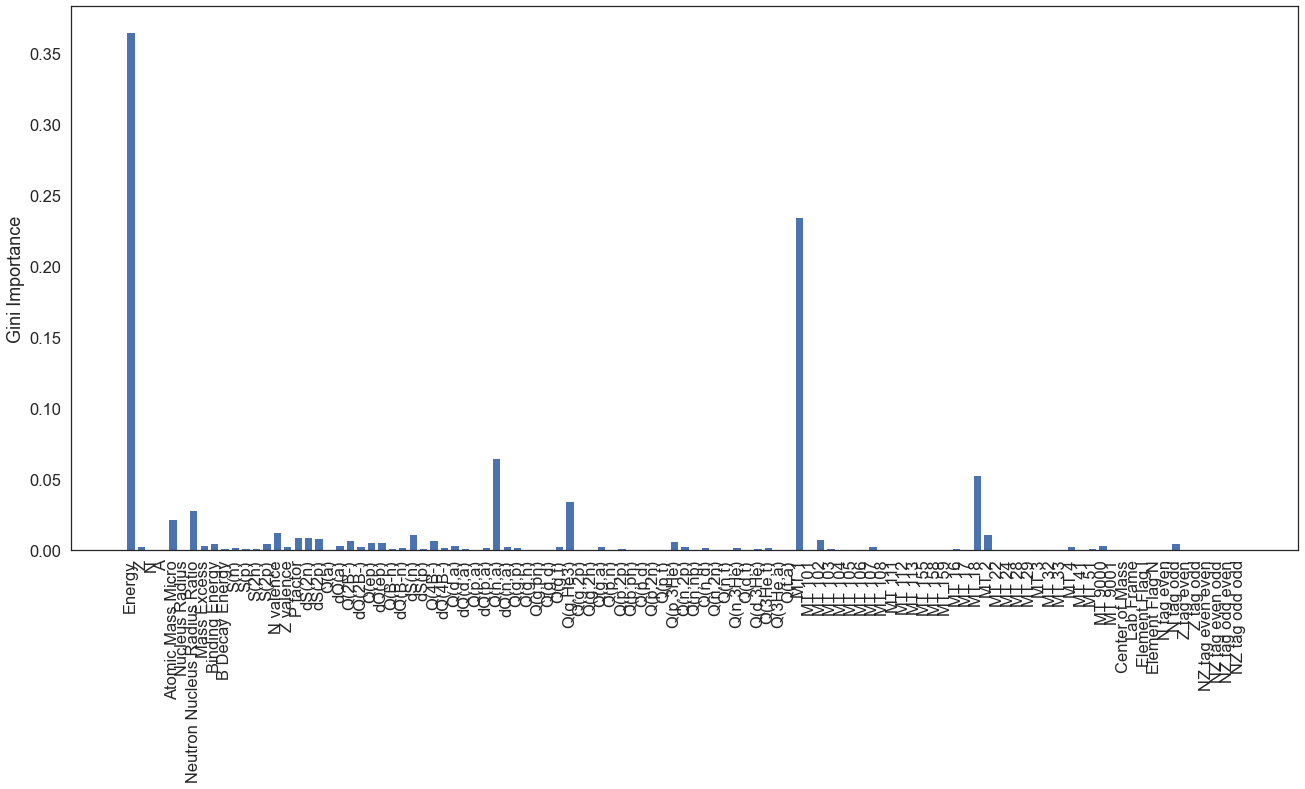

In [233]:
plt.figure(figsize=(22,10))
plt.bar([x for x in range(len(b4_train_model.feature_importances_))], b4_train_model.feature_importances_)
plt.xticks(np.arange(len(columns_b4)), columns_b4, rotation=90) 
plt.ylabel("Gini Importance")
plt.savefig("figures/dt_feat_import_b4.png", bbox_inches='tight', dpi=300)
plt.show()

In [111]:
# import plotly.express as px

# fig = px.scatter_3d(results_b0, x='max_depth', y='msl', z='train_mae', color='train_mae', 
#                     title="Minimum Samples in Leaf - Train Dataset")

# fig.update_layout(scene = dict(
#                     xaxis_title='Max Depth',
#                     yaxis_title='MSL',
#                     zaxis_title='Train MAE'),
#                     width=700,
#                     margin=dict(r=20, b=10, l=10, t=10)
#                  )

# fig.show()
# # fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_train.svg"))
# # fig.write_html(os.path.join(figure_disr, "Parameter_Tuning/dt_msl_train.html"))

# fig = px.scatter_3d(results_b0, x='max_depth', y='mss', z='train_mae', color='train_mae', 
#                     title="Minimum Samples in Leaf - Test Dataset")
# fig.show()

# fig = px.scatter_3d(results_b0, x='max_depth', y='msl', z='test_mae', color='test_mae', 
#                     title="Minimum Samples in Leaf - Test Dataset")
# fig.show()
# # fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_test.svg"))
# # fig.write_html(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_test.html"))

# fig = px.scatter_3d(results_b0, x='max_depth', y='mss', z='test_mae', color='test_mae', 
#                     title="Minimum Samples in Leaf - Test Dataset")
# fig.show()

# fig = px.scatter_3d(dt_results, x='max_depth', y='msl', z='train_mae', color='train_mae', 
#                     title="Minimum Samples in Leaf - Train Dataset")
# fig.show()
# fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_train.svg"))
# fig.write_html(os.path.join(figure_disr, "Parameter_Tuning/dt_msl_train.html"))

# fig = px.scatter_3d(dt_results, x='max_depth', y='msl', z='test_mae', color='test_mae', 
#                     title="Minimum Samples in Leaf - Test Dataset")
# fig.show()
# fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_test.svg"))
# fig.write_html(os.path.join(figure_dir, "Parameter_Tuning/dt_msl_test.html"))

# fig = px.scatter_3d(dt_results, x='max_depth', y='mss', z='train_mae', color='train_mae',
#                     title="Minimum Samples for Split - Train Dataset")
# fig.show()
# fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_mss_train.svg"))
# fig.write_html(os.path.join(figure_dir, "Parameter_Tuning/dt_mss_train.html"))

# fig = px.scatter_3d(dt_results, x='max_depth', y='mss', z='test_mae', color='test_mae',
#                     title="Minimum Samples for Split - Test Dataset")
# fig.show()
# fig.write_image(os.path.join(figure_dir, "Parameter_Tuning/dt_mss_test.svg"))
# fig.write_html(os.path.join(figure_dir, "Parameter_Tuning/dt_mss_test.html"))